In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import itertools

2024-12-09 12:06:17.217977: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 12:06:17.219376: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 12:06:17.223830: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 12:06:17.234998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733745977.252902   65265 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733745977.25

In [ ]:
import os
os.system("unzip 'CroppedFaces6.zip' -d '/home/dapeused/Dataset/Data Gathering'")

In [ ]:
import os
import shutil

# Direktori sumber dan tujuan
source_dir = '/home/dapeused/Dataset/Data Gathering/CroppedFaces4'
new_folder_dir = '/home/dapeused/Dataset/Data Gathering/fair'  # Folder baru untuk file yang dimulai dengan "training"

# Membuat folder baru jika belum ada
os.makedirs(new_folder_dir, exist_ok=True)

# Dapatkan semua kelas dalam folder sumber
classes = os.listdir(source_dir)

# Iterasi setiap kelas
for cls in classes:
    cls_source_dir = os.path.join(source_dir, cls)
    
    # Dapatkan semua file dalam folder kelas
    files = os.listdir(cls_source_dir)
    
    # Pindahkan file yang nama depannya "training"
    for file in files:
        if file.startswith("Training_"):  # Mengecek jika nama file dimulai dengan "training"
            source_file_path = os.path.join(cls_source_dir, file)
            destination_file_path = os.path.join(new_folder_dir, file)
            
            # Pindahkan file ke folder tujuan
            shutil.move(source_file_path, destination_file_path)  # Bisa menggunakan copy() atau move()
            print(f"File {file} telah dipindahkan ke {new_folder_dir}")


In [29]:
import os

def count_files_in_folder(parent_folder):
    total_files = 0  # Variabel untuk menghitung jumlah file
    folder_summary = {}  # Dictionary untuk menyimpan jumlah file per child folder
    
    # Iterasi melalui folder parent
    for root, dirs, files in os.walk(parent_folder):
        if root == parent_folder:
            continue  # Lewati folder parent (hanya ingin menghitung file dalam child folder)
        
        # Hitung jumlah file di child folder
        num_files = len(files)
        folder_name = os.path.basename(root)  # Nama child folder
        folder_summary[folder_name] = num_files
        total_files += num_files
    
    return total_files, folder_summary

# Path ke folder parent
parent_folder = "/home/dapeused/Dataset/Data Gathering/CroppedFaces4"
# parent_folder = "/home/dapeused/Dataset/Facial Emotion/train_crop"

# Hitung jumlah file
total_files, folder_summary = count_files_in_folder(parent_folder)

# Tampilkan hasil
print(f"Total jumlah file di semua folder child: {total_files}")
print("Jumlah file per folder child:")
for folder, count in folder_summary.items():
    print(f"  - {folder}: {count} file")


Total jumlah file di semua folder child: 18952
Jumlah file per folder child:
  - Neutral: 3219 file
  - Happy: 4004 file
  - Anger: 2826 file
  - Sad: 2171 file
  - Surprised: 2469 file
  - Disgust: 1532 file
  - Fear: 2731 file


In [27]:
import os
import shutil
import random

# Direktori awal, training, dan validation
source_dir = '/home/dapeused/Dataset/Facial Emotion/train_crop'
train_dir = '/home/dapeused/Dataset/Data Gathering/CroppedFaces4'
val_dir = '/home/dapeused/Dataset/Data Gathering/fair'  # Folder baru untuk validation

# Dapatkan semua kelas dalam folder sumber
classes = os.listdir(source_dir)

# Iterasi setiap kelas
for cls in classes:
    cls_source_dir = os.path.join(source_dir, cls)
    cls_train_dir = os.path.join(train_dir, cls)
    cls_val_dir = os.path.join(val_dir, cls)
    
    # Buat folder kelas di train dan val jika belum ada
    os.makedirs(cls_train_dir, exist_ok=True)
    os.makedirs(cls_val_dir, exist_ok=True)

    # Dapatkan semua file dalam folder kelas
    files = os.listdir(cls_source_dir)
    random.shuffle(files)
    
    # Tentukan jumlah file untuk train dan val
    num_train_files = int(0.5 * len(files))  # 70% untuk training
    num_val_files = len(files) - num_train_files  # 30% untuk validation

    # Pindahkan file ke folder train
    for file in files[:num_train_files]:
        shutil.copy(os.path.join(cls_source_dir, file), os.path.join(cls_train_dir, file))
    
    # Pindahkan file sisanya ke folder val
    for file in files[num_train_files:]:
        shutil.copy(os.path.join(cls_source_dir, file), os.path.join(cls_val_dir, file))


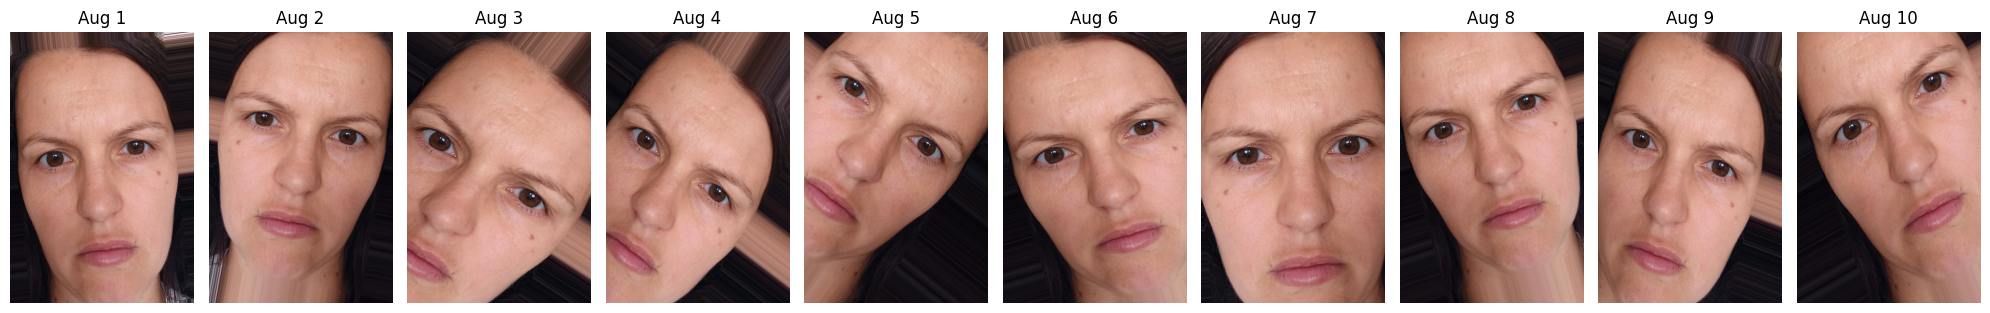

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Memuat gambar pertama dari dataset (sesuaikan dengan path gambar Anda)
image_path = '/home/dapeused/Dataset/Facial Emotion/train_crop/Train_Cropface/0/Anger_face0.jpg'  # Ganti dengan path gambar Anda
image = load_img(image_path)
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

# Buat generator augmentasi dari gambar yang sudah dimuat
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True, 
    rotation_range=40, 
    zoom_range=0.15,
    height_shift_range=0.03,
    width_shift_range=0.1,
    validation_split=0.1,
    fill_mode='nearest',
)



augmented_images = train_datagen.flow(image, batch_size=1)

# Tampilkan beberapa hasil augmentasi
fig, axes = plt.subplots(1, 10, figsize=(20, 5))  # Lebih lebar agar semua terlihat

for i in range(10):  # Menampilkan 10 hasil augmentasi
    augmented_image = next(augmented_images)[0]  # Menggunakan next untuk mendapatkan gambar
    augmented_image = np.clip(augmented_image * 255, 0, 255).astype('uint8')  # Normalisasi ke 0-255
    axes[i].imshow(augmented_image)
    axes[i].set_title(f"Aug {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [14]:
import os
import cv2
import numpy as np

# Direktori data
# DATA_DIR = '/home/dapeused/Dataset/Facial Emotion/train_crop'
# DATA_DIR2 = '/home/dapeused/Dataset/Data Gathering/CroppedFaces6'
DATA_DIR3 = '/home/dapeused/Dataset/Data Gathering/CroppedFaces4'
# DATA_DIR4 = '/home/dapeused/Dataset/fer2013/train'
# DATA_DIR5 = '/home/dapeused/Dataset/fer2013/val'
IMG_SIZE = 128
batch_size = 32

# Daftar emosi
EMOTIONS = ["Anger", "Fear", "Surprised", "Happy", "Sad", "Disgust", "Neutral"]

def load_data():
    images = []
    labels = []
    
    # Loop melalui daftar emosi
    for emotion_label, emotion in enumerate(EMOTIONS):
        # Directory untuk emosi saat ini (di DATA_DIR dan DATA_DIR2)
        emotion_dirs = [os.path.join(DATA_DIR3, emotion)] 
                        # os.path.join(DATA_DIR2, emotion),
                        # [os.path.join(DATA_DIR3, emotion)]
                        # # os.path.join(DATA_DIR4, emotion), 
                        # os.path.join(DATA_DIR5, emotion)]
        
        for emotion_dir in emotion_dirs:
            # Hanya load data label 'Disgust' dari DATA_DIR2
            # if emotion_dir.startswith(DATA_DIR) and emotion != "Disgust":
            #     continue

            # if emotion_dir.startswith(DATA_DIR2) and emotion != "Disgust":
            #     continue

            # if emotion_dir.startswith(DATA_DIR3) and emotion != "Disgust":
            #     continue

            # if emotion_dir.startswith(DATA_DIR4):
            #     if emotion not in ["Neutral", "Happy"]:
            #         continue 

            # if emotion_dir.startswith(DATA_DIR5):
            #     if emotion not in ["Neutral", "Happy"]:
            #         continue   
            
            # Periksa apakah direktori emosi ada
            if os.path.isdir(emotion_dir):
                for img_file in os.listdir(emotion_dir):
                    img_path = os.path.join(emotion_dir, img_file)
                    
                    # Membaca dan memproses gambar
                    img_array = cv2.imread(img_path)
                    if img_array is None:
                        print(f"Warning: Unable to read {img_path}")
                        continue

                    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                    img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                    img_rescaled = img_resized / 255.0
                    images.append(img_rescaled)
                    labels.append(emotion_label)
            else:
                print(f"Directory not found for emotion {emotion}: {emotion_dir}")
    
    return np.array(images), np.array(labels)

images,labels = load_data()


In [ ]:
import os
import cv2
import numpy as np
import random

# Direktori data
DATA_DIR = '/home/dapeused/Dataset/Facial Emotion/train_crop'
DATA_DIR2 = '/home/dapeused/Dataset/Data Gathering/CroppedFaces6'
DATA_DIR3 = '/home/dapeused/Dataset/Data Gathering/CroppedFaces4'
DATA_DIR4 = '/home/dapeused/Dataset/fer2013/train'
# DATA_DIR5 = '/home/dapeused/Dataset/Data Gathering/CroppedFaces1'
IMG_SIZE = 224
batch_size = 32

# Daftar emosi
EMOTIONS = ["Anger", "Fear", "Surprised", "Happy", "Sad", "Disgust", "Neutral"]

def load_data():
    images = []
    labels = []
    
    # Loop melalui daftar emosi
    for emotion_label, emotion in enumerate(EMOTIONS):
        # Directory untuk emosi saat ini (di DATA_DIR dan DATA_DIR2)
        emotion_dirs = [os.path.join(DATA_DIR, emotion), 
                        os.path.join(DATA_DIR2, emotion),
                        os.path.join(DATA_DIR3, emotion),
                        os.path.join(DATA_DIR4, emotion)]
                        # os.path.join(DATA_DIR5, emotion)]
        
        for emotion_dir in emotion_dirs:
            
            # if emotion_dir.startswith(DATA_DIR5):
            #     if emotion not in ["Neutral", "Happy"]:
            #         continue 

            # Jika berada di DATA_DIR4, hanya ambil 30% gambar
            if emotion_dir.startswith(DATA_DIR4):
                if emotion not in [ "Anger", "Fear", "Surprised", "Happy", "Sad", "Disgust", "Neutral"]:
                    continue

                # Ambil semua gambar dari direktori emosi di DATA_DIR4
                all_images = []
                for img_file in os.listdir(emotion_dir):
                    img_path = os.path.join(emotion_dir, img_file)

                    # Membaca dan memproses gambar
                    img_array = cv2.imread(img_path)
                    if img_array is None:
                        print(f"Warning: Unable to read {img_path}")
                        continue

                    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                    img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                    img_rescaled = img_resized / 255.0
                    all_images.append(img_rescaled)

                # Mengacak gambar dan mengambil 30% dari total gambar yang ada
                random.shuffle(all_images)
                thirty_percent_images = all_images[:len(all_images) //5 ]  

                # Menambahkan gambar yang diambil ke list
                images.extend(thirty_percent_images)
                labels.extend([emotion_label] * len(thirty_percent_images))
                continue

            # Untuk direktori lainnya, ambil semua gambar
            if os.path.isdir(emotion_dir):
                for img_file in os.listdir(emotion_dir):
                    img_path = os.path.join(emotion_dir, img_file)
                    
                    # Membaca dan memproses gambar
                    img_array = cv2.imread(img_path)
                    if img_array is None:
                        print(f"Warning: Unable to read {img_path}")
                        continue

                    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                    img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                    img_rescaled = img_resized / 255.0
                    images.append(img_rescaled)
                    labels.append(emotion_label)
            else:
                print(f"Directory not found for emotion {emotion}: {emotion_dir}")
    
    return np.array(images), np.array(labels)

images, labels = load_data()


: 

In [ ]:
thirty 

In [20]:
import numpy as np

# Misalnya labels adalah array yang berisi label kelas untuk tiap gambar
# labels.shape = (jumlah_data,)

# Daftar nama kelas
EMOTIONS = ["Anger", "Fear", "Surprised", "Happy", "Sad", "Disgust", "Neutral"]

# Menghitung jumlah sampel pada tiap kelas
unique_labels, counts = np.unique(labels, return_counts=True)

# Menampilkan hasilnya dengan nama kelas
print("Jumlah sampel pada tiap kelas:")
for label, count in zip(unique_labels, counts):
    class_name = EMOTIONS[label]  # Mengganti indeks kelas dengan nama kelas
    print(f"Class: {class_name}, Sampel: {count}")


Jumlah sampel pada tiap kelas:
Class: Anger, Sampel: 4415
Class: Fear, Sampel: 4360
Class: Surprised, Sampel: 3728
Class: Happy, Sampel: 6881
Class: Sad, Sampel: 3143
Class: Disgust, Sampel: 1698
Class: Neutral, Sampel: 5196


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameter dasar
img_size = 128  # Ukuran gambar
batch_size = 32  # Ukuran batch
validation_split = 0.2  # 10% data untuk validasi

# ImageDataGenerator untuk training (dengan augmentasi)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range = 45,  # Normalisasi
    validation_split=validation_split  # Membagi dataset menjadi train dan validation
)

# Generator untuk training (90% data)
train_generator = train_datagen.flow_from_directory(
    directory='/home/dapeused/Dataset/Data Gathering/CroppedFaces4',
    shuffle=True,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Data untuk training
)

# Generator untuk validation (10% data)
val_generator = train_datagen.flow_from_directory(
    directory='/home/dapeused/Dataset/Data Gathering/CroppedFaces4',
    shuffle=True,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Data untuk validation
)

# Generator untuk testing
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Hanya normalisasi
test_generator = test_datagen.flow_from_directory(
    directory='/home/dapeused/Dataset/Facial Emotion/train_crop',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',  # Gunakan grayscale jika diperlukan
    color_mode='rgb'  # Ubah ke 'grayscale' jika dataset grayscale
)


Found 15165 images belonging to 7 classes.
Found 3787 images belonging to 7 classes.
Found 133 images belonging to 7 classes.


In [22]:
# Menampilkan jumlah sampel per kelas
class_counts = train_generator.classes  # Mengambil semua label kelas
unique_classes, class_count = np.unique(class_counts, return_counts=True)

# Menampilkan hasil
for cls, count in zip(unique_classes, class_count):
    class_name = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(cls)]
    print(f"Kelas '{class_name}': {count} sampel")

Kelas 'Anger': 1619 sampel
Kelas 'Disgust': 1393 sampel
Kelas 'Fear': 1493 sampel
Kelas 'Happy': 1831 sampel
Kelas 'Neutral': 1721 sampel
Kelas 'Sad': 1427 sampel
Kelas 'Surprised': 1509 sampel


In [15]:
# Normalize images
# images = images / 255.0

# Encode labels to categorical
labels_categorical = to_categorical(labels, num_classes=len(EMOTIONS))

In [19]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.1, stratify=labels_categorical, random_state=123)

In [5]:
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {y_test.shape}")

X_train shape: (23536, 128, 128, 3)
Y_train shape: (23536, 7)
X_test shape: (5885, 128, 128, 3)
Y_test shape: (5885, 7)


In [23]:
# Reshape for the model
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
# images_test = images_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

train_datagen = ImageDataGenerator(
    rescale=1./255
    # horizontal_flip=True, 
    # rotation_range=40, 
    # zoom_range=0.15,
    # height_shift_range=0.03,
    # width_shift_range=0.1,
    # validation_split=0.1,
    # fill_mode='nearest'
)

validation_datagen =ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train,
y_train,
batch_size = batch_size)

validation_generator = validation_datagen.flow( X_test,
y_test,
batch_size = batch_size)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, GlobalAveragePooling2D, GRU, Flatten, Dense, Dropout, Reshape,BatchNormalization, ReLU
)

# Model Sequential
model = Sequential()

# Layer 1 - Convolution 3x3 (32 filters) + ReLU + BatchNormalization
model.add(Conv2D(32, (3, 3), activation=None, input_shape=(141, 141, 3)))
model.add(ReLU())  # Aktivasi ReLU
model.add(BatchNormalization())  # Normalisasi setelah convolution


# Layer 2 - Convolution 3x3 (64 filters) + ReLU + BatchNormalization
model.add(Conv2D(64, (3, 3), activation=None))
model.add(ReLU())  # Aktivasi ReLU
model.add(BatchNormalization())  # Normalisasi


# Layer 3 - Convolution 3x3 (128 filters) + ReLU + BatchNormalization
model.add(Conv2D(128, (3, 3), activation=None))
model.add(ReLU())  # Aktivasi ReLU
model.add(BatchNormalization())  # Normalisasi

# Layer 4 - Convolution 3x3 (128 filters) + ReLU + BatchNormalization
model.add(Conv2D(192, (3, 3), activation=None))
model.add(ReLU())  # Aktivasi ReLU
model.add(BatchNormalization())  # Normalisasi

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Reshape the data for GRU input (timesteps, features)
model.add(Reshape((1, -1)))  # Reshape menjadi (timesteps, features)

# GRU Layers
model.add(GRU(140, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(GRU(90, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(GRU(30, return_sequences=False, activation='tanh'))
model.add(Dropout(0.5))

# Fully Connected Layers
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(124, activation='relu'))
# model.add(Dropout(0.1))

# Output Layer - Dense 7 + Softmax
model.add(Dense(7, activation='softmax'))
# model.summary()

# # # Model Checkpoint
mcp_save = ModelCheckpoint(
    '/home/dapeused/model2/cnnGRU_datagatheringfer128.keras',
    save_best_only=True, 
    monitor='val_loss', 
    mode='min'
)
callbacks_list = [mcp_save]

# Compile and Fit
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(train_generator, epochs=35, callbacks=callbacks_list, validation_data=val_generator)
# history = model.fit(X_train,y_train, epochs=30, callbacks = callbacks_list,validation_data = (X_test,y_test))

In [ ]:
history = model.fit(train_generator, epochs=15, callbacks=callbacks_list, validation_data=val_generator)

In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation, Input
# from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model

pretrained_model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
pretrained_model.trainable = False

x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
# x = Dropout(0.1)(x)
x=Dense(1024,activation='relu')(x) 
x = Dropout(0.1)(x)
x=Dense(1024,activation='relu')(x) 
x = Dropout(0.1)(x)
x=Dense(256,activation='relu')(x)
x = Dropout(0.1)(x)
# x=Dense(128,activation='relu')(x) 
# x = Dropout(0.2)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.1)(x)
# x = Dense(2, activation='softmax')(x)

predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)

model.summary()


# mcp_save = ModelCheckpoint('/home/dapeused/model2/mobilenet_datagathering.keras', save_best_only=True, monitor='val_loss', mode='min')
# callbacks_list = [mcp_save]

# # opt = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-7, decay=1e-5)
# model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
# history = model.fit(train_generator, epochs=3, callbacks = callbacks_list,validation_data=val_generator)
# history = model.fit(X_train,y_train, epochs=30, callbacks = callbacks_list,validation_data = (X_test,y_test))

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,888,647 (18.65 MB)

 Trainable params: 2,628,103 (10.03 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import tensorflow as tf

# Load pretrained EfficientNetB0 model
pretrained_model = tf.keras.applications.EfficientNetB0(
    weights="imagenet",          # Bobot pretrained dari ImageNet
    include_top=False,           # Hapus layer Fully Connected (top layer)
    input_shape=(224, 224, 3)    # Bentuk input gambar
)

# Membuat pretrained model tidak dapat dilatih
pretrained_model.trainable = False

# Tambahkan lapisan custom di atas EfficientNetB0
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
# x = Dense(128, activation='relu')(x)  # Fully Connected Layer
x = Dropout(0.2)(x)  # Dropout jika diperlukan
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.1)(x)
predictions = Dense(7, activation='softmax')(x)  # Output Layer (7 kelas)

# Definisikan model
model = Model(inputs=pretrained_model.input, outputs=predictions)

# Callbacks untuk menyimpan model terbaik berdasarkan val_loss
mcp_save = ModelCheckpoint(
    '/home/dapeused/model2/efficientnetb0_face_datagathering.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)
callbacks_list = [mcp_save]

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(
    optimizer=opt,  # Optimizer yang digunakan
    loss='categorical_crossentropy',  # Loss function untuk multi-class classification
    metrics=['accuracy']  # Metric yang dipantau
)

# Train model
history = model.fit(
    train_generator,
    epochs=25,
    callbacks=callbacks_list,
    validation_data=val_generator
)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load pretrained VGG16 model
pretrained_model = tf.keras.applications.VGG16(
    weights="imagenet",          # Bobot pretrained dari ImageNet
    include_top=False,           # Hapus layer Fully Connected (top layer)
    input_shape=(224, 224, 3)    # Bentuk input gambar
)

# Membuat pretrained model tidak dapat dilatih
pretrained_model.trainable = False

# Tambahkan lapisan custom di atas VGG16
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(128, activation='relu')(x)  # Fully Connected Layer
# x = Dropout(0.5)(x)  # Dropout
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.1)(x)
predictions = Dense(7, activation='softmax')(x)  # Output Layer (7 kelas)

# Definisikan model
model = Model(inputs=pretrained_model.input, outputs=predictions)

# Callbacks untuk menyimpan model terbaik berdasarkan val_loss
mcp_save = ModelCheckpoint(
    '/home/dapeused/model2/vgg16_face_datagathering.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)
callbacks_list = [mcp_save]

# Optimizer
# opt = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-7, decay=1e-5)

# Compile model
model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_generator,
    epochs=5,
    callbacks=callbacks_list,
    validation_data=val_generator
)


In [ ]:
history = model.fit(train_generator, epochs=10, callbacks = callbacks_list,validation_data=val_generator)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model

# Load Pretrained InceptionV3 model tanpa fully connected layers
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(128,128,3))
# Freeze layer dasar untuk transfer learning
base_model.trainable = False

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = x = Flatten()(x)  # Global Average Pooling menggantikan Flatten
# x = Dropout(dropout_rate)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(dropout_rate)(x)
output = Dense(7, activation='softmax')(x)  # Softmax untuk klasifikasi multi-kelas

# Membuat model
model = Model(inputs=base_model.input, outputs=output)
opt = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-7, decay=1e-5)

mcp_save = ModelCheckpoint('/home/dapeused/model1/inception_face_datagatheringfer.keras', save_best_only=True, monitor='val_loss', mode='min')
callbacks_list = [mcp_save]

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# history = model.fit(train_generator, epochs=20, callbacks = callbacks_list,validation_data=val_generator)
history = model.fit(X_train,y_train, epochs=20, callbacks = callbacks_list,validation_data = (X_test,y_test))

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.optimizers import SGD

ResNet50_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layers in ResNet50_model.layers:
    layers.trainable=True

opt = SGD(learning_rate=0.01,momentum=0.7)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(7,activation='softmax')(resnet50_x)

model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
# opt = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-7, decay=1e-5)

mcp_save = ModelCheckpoint('/home/dapeused/model1/inception_face_datagathering.keras', save_best_only=True, monitor='val_loss', mode='min')
callbacks_list = [mcp_save]

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=20, callbacks = callbacks_list,validation_data=val_generator)

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
from keras.models import load_model
# model.save("/home/dapeused/model1/mobilenet1_face_datagatheringfer.keras")
model = load_model('/home/dapeused/model1.keras')

# Periksa input shape
input_shape = model.input_shape
print("Input shape:", input_shape)

Input shape: (None, 128, 128, 3)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Asumsi test_generator sudah didefinisikan sebelumnya
# Misalnya test_generator = datagen.flow_from_directory(...)

# Memperoleh prediksi dari model menggunakan test_generator tanpa parameter steps
y_pred = model.predict(val_generator, verbose=1)

# Mengambil kelas prediksi (bentuk argmax untuk prediksi kelas)
y_pred_classes = np.argmax(y_pred, axis=1)

# Mengambil true labels dari generator
y_true = val_generator.classes

# Mendapatkan nama kelas
class_names = val_generator.class_indices.keys()

# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Menampilkan classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Menambahkan jumlah data di dalam sel confusion matrix
thresh = cm.max() / 2  # Untuk penentuan warna anotasi
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.show()



119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

22/60 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step
Classification Report:
              precision    recall  f1-score   support

       Anger       0.99      0.57      0.72       283
        Fear       1.00      0.50      0.67       273
   Surprised       0.99      0.63      0.77       247
       Happy       0.63      0.86      0.73       401
         Sad       1.00      0.65      0.79       217
     Disgust       0.99      0.95      0.97       153
     Neutral       0.48      0.90      0.62       322

    accuracy                           0.73      1896
   macro avg       0.87      0.72      0.75      1896
weighted avg       0.83      0.73      0.73      1896



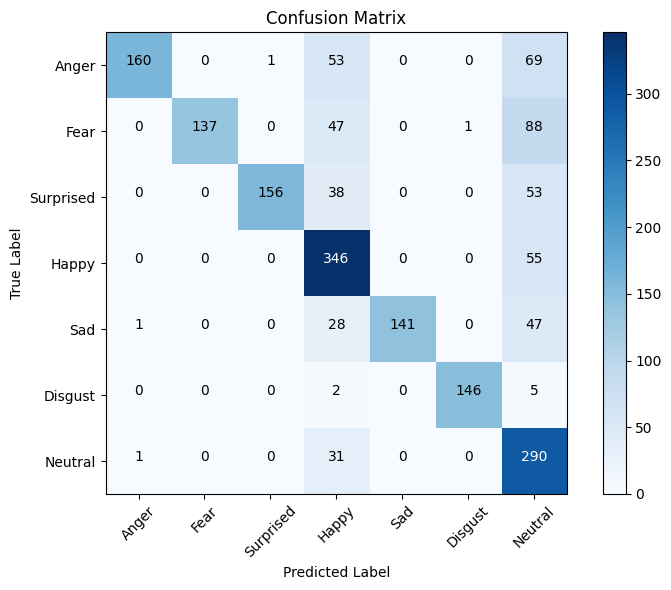

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Pastikan X_test dan y_test sudah didefinisikan
# X_test: data input untuk pengujian
# y_test: label sebenarnya untuk pengujian
# EMOTIONS: daftar nama emosi (kelas)

# Memperoleh prediksi dari model
y_pred = model.predict(X_test, verbose=1)

# Mengambil kelas prediksi (argmax digunakan jika output berupa probabilitas)
y_pred_classes = np.argmax(y_pred, axis=1)

# Pastikan y_test memiliki bentuk yang sesuai (convert jika multilabel-indicator)
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Menampilkan classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=EMOTIONS))

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Mengatur label pada sumbu
tick_marks = np.arange(len(EMOTIONS))
plt.xticks(tick_marks, EMOTIONS, rotation=45)
plt.yticks(tick_marks, EMOTIONS)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Menambahkan anotasi jumlah data pada masing-masing sel
thresh = cm.max() / 2  # Warna anotasi berdasarkan ambang batas
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()
